(log-gaussian-cox-process)=
# Modeling spatial point patterns with a marked log-Gaussian Cox process

:::{post} May 31, 2022
:tags: cox process, latent gaussian process, nonparametric, spatial, count data
:category: intermediate
:author: Chrisopher Krapu, Chris Fonnesbeck
:::

## Introduction

The log-Gaussian Cox process (LGCP) is a probabilistic model of point patterns typically observed in space or time. It has two main components. First, an underlying *intensity* field $\lambda(s)$ of positive real values is modeled over the entire domain $X$ using an exponentially-transformed Gaussian process which constrains $\lambda$ to be positive. Then, this intensity field is used to parameterize a [Poisson point process](https://en.wikipedia.org/wiki/Poisson_point_process) which represents a stochastic mechanism for placing points in space. Some phenomena amenable to this representation include the incidence of cancer cases across a county, or the spatiotemporal locations of crime events in a city. Both spatial and temporal dimensions can be handled equivalently within this framework, though this tutorial only addresses data in two spatial dimensions.

In more formal terms, if we have a space $X$ and $A\subseteq X$, the distribution over the number of points $Y_A$ occurring within subset $A$ is given by
$$Y_A \sim Poisson\left(\int_A \lambda(s) ds\right)$$
and the intensity field is defined as
$$\log \lambda(s) \sim GP(\mu(s), K(s,s'))$$
where $GP(\mu(s), K(s,s'))$ denotes a Gaussian process with mean function $\mu(s)$ and covariance kernel $K(s,s')$ for a location $s \in X$. This is one of the simplest models of point patterns of $n$ events recorded as locations $s_1,...,s_n$ in an arbitrary metric space. In conjunction with a Bayesian analysis, this model can be used to answering questions of interest such as:
* Does an observed point pattern imply a statistically significant shift in spatial intensities?
* What would randomly sampled patterns with the same statistical properties look like?
* Is there a statistical correlation between the *frequency* and *magnitude* of point events?

In this notebook, we'll use a grid-based approximation to the full LGCP with PyMC to fit a model and analyze its posterior summaries. We will also explore the usage of a marked Poisson process, an extension of this model to account for the distribution of *marks* associated with each data point.

## Data

Our observational data concerns 231 sea anemones whose sizes and locations on the French coast were recorded. This data was taken from the [`spatstat` spatial modeling package in R](https://github.com/spatstat/spatstat) which is designed to address models like the LGCP and its subsequent refinements. The original source of this data is the textbook *Spatial data analysis by example* by Upton and Fingleton (1985) and a longer description of the data can be found there.

In [1]:
import warnings

from itertools import product

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from matplotlib import MatplotlibDeprecationWarning
from numpy.random import default_rng

warnings.filterwarnings(action="ignore", category=MatplotlibDeprecationWarning)

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
data = pd.read_csv(pm.get_data("anemones.csv"))
n = data.shape[0]

This dataset has coordinates and discrete mark values for each anemone. While these marks are integers, for the sake of simplicity we will model these values as continuous in a later step.

In [4]:
data.head(3)

,x,y,marks
0,27,7,6
1,197,5,4
2,74,15,4


Let's take a look at this data in 2D space:

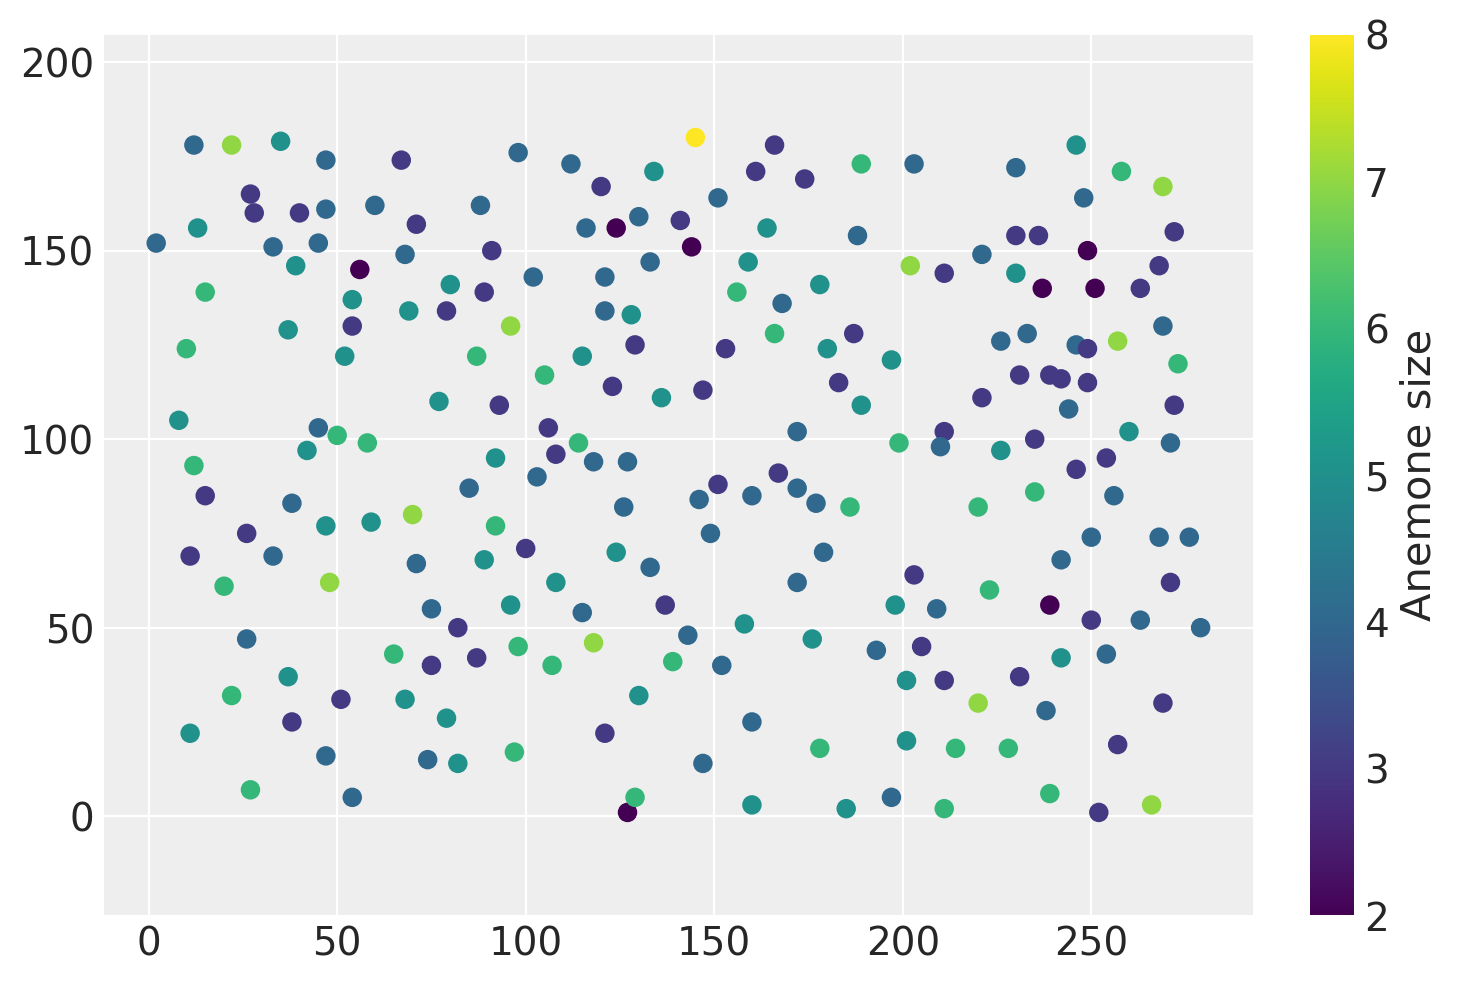

In [5]:
plt.scatter(data["x"], data["y"], c=data["marks"])
plt.colorbar(label="Anemone size")
plt.axis("equal");

The 'marks' column indicates the size of each anemone. If we were to model both the marks and the spatial distribution of points, we would be modeling a *marked Poisson point process*. Extending the basic point pattern model to include this feature is the second portion of this notebook.

While there are multiple ways to conduct inference, perhaps the  simplest way is to slice up our domain $X$ into many small pieces $A_1, A_2,...,A_M$ and fix the intensity field to be constant within each subset. Then, we will treat the number of points within each $A_j$ as a Poisson random variable such that $Y_j \sim Poisson(\lambda_j)$. and we also consider the $\log{\lambda_1}...,\log{\lambda_M}$ variables as a single draw from a Gaussian process.

The code below splits up the domain into grid cells, counts the number of points within each cell and also identifies its centroid.

In [6]:
xy = data[["x", "y"]].values

# Jitter the data slightly so that none of the points fall exactly
# on cell boundaries
eps = 1e-3
rng = default_rng()
xy = xy.astype("float") + rng.standard_normal(xy.shape) * eps

resolution = 20

# Rescaling the unit of area so that our parameter estimates
# are easier to read
area_per_cell = resolution**2 / 100

cells_x = int(280 / resolution)
cells_y = int(180 / resolution)

# Creating bin edges for a 2D histogram
quadrat_x = np.linspace(0, 280, cells_x + 1)
quadrat_y = np.linspace(0, 180, cells_y + 1)

# Identifying the midpoints of each grid cell
centroids = np.asarray(list(product(quadrat_x[:-1] + 10, quadrat_y[:-1] + 10)))

cell_counts, _, _ = np.histogram2d(xy[:, 0], xy[:, 1], [quadrat_x, quadrat_y])
cell_counts = cell_counts.ravel().astype(int)

With the points split into different cells and the cell centroids computed, we can plot our new gridded dataset as shown below.

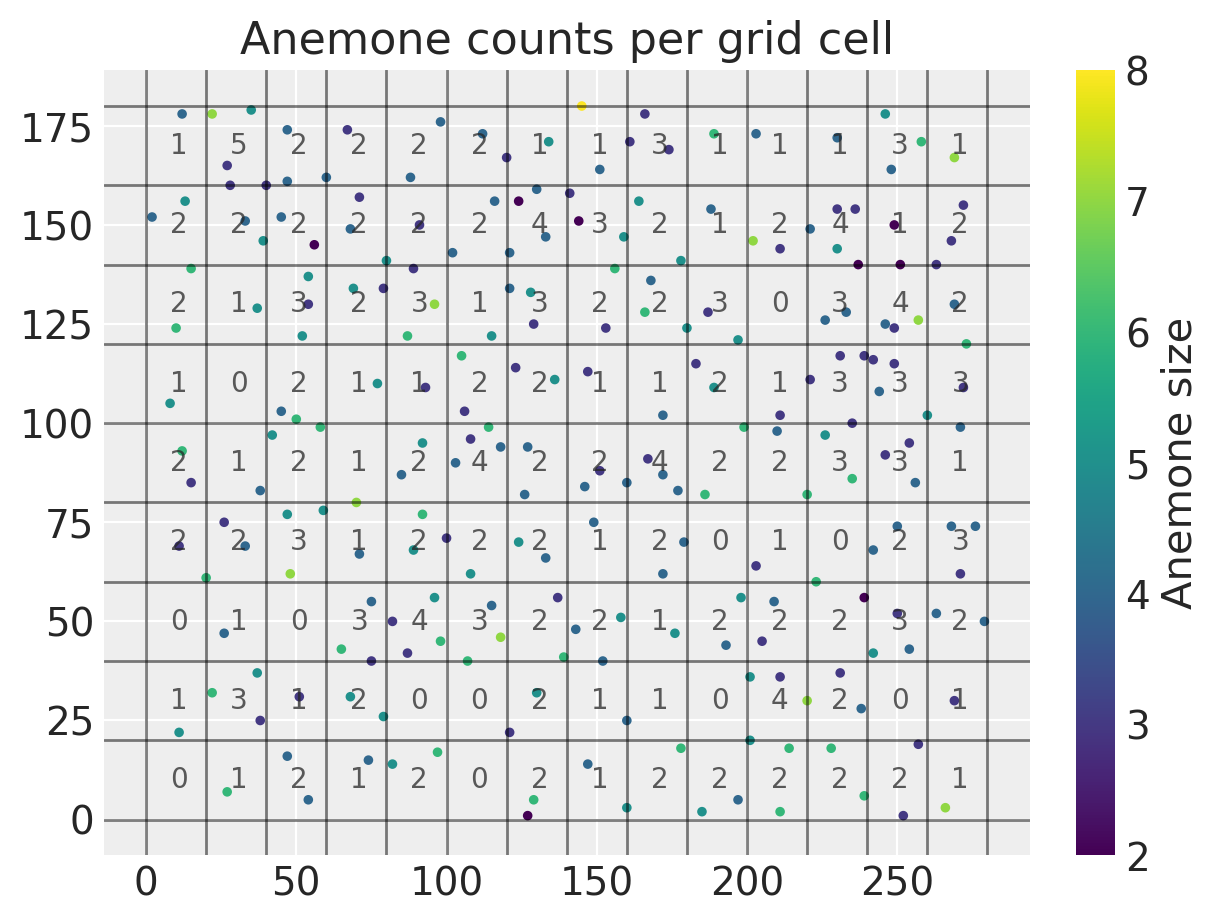

In [7]:
line_kwargs = {"color": "k", "linewidth": 1, "alpha": 0.5}

plt.figure(figsize=(6, 4.5))
[plt.axhline(y, **line_kwargs) for y in quadrat_y]
[plt.axvline(x, **line_kwargs) for x in quadrat_x]
plt.scatter(data["x"], data["y"], c=data["marks"], s=6)

for i, row in enumerate(centroids):
    shifted_row = row - 2
    plt.annotate(cell_counts[i], shifted_row, alpha=0.75)

plt.title("Anemone counts per grid cell"), plt.colorbar(label="Anemone size");

We can see that all of the counts are fairly low and range from zero to five. With all of our data prepared, we can go ahead and start writing out our probabilistic model in PyMC. We are going to treat each of the per-cell counts $Y_1,...Y_M$ above as a Poisson random variable.

# Inference

Our first step is to place prior distributions over the high-level parameters for the Gaussian process. This includes the length scale $\rho$ for the covariance function and a constant mean $\mu$ for the GP.

In [8]:
with pm.Model() as lgcp_model:
    mu = pm.Normal("mu", sigma=3)
    rho = pm.Uniform("rho", lower=25, upper=300)
    variance = pm.InverseGamma("variance", alpha=1, beta=1)
    cov_func = variance * pm.gp.cov.Matern52(2, ls=rho)
    mean_func = pm.gp.mean.Constant(mu)

Next, we transform the Gaussian process into a positive-valued process via `pm.math.exp` and use the area per cell to transform the intensity function $\lambda(s)$ into rates $\lambda_i$ parameterizing the Poisson likelihood for the counts within cell $i$.

In [9]:
with lgcp_model:
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)

    log_intensity = gp.prior("log_intensity", X=centroids)
    intensity = pm.math.exp(log_intensity)

    rates = intensity * area_per_cell
    counts = pm.Poisson("counts", mu=rates, observed=cell_counts)

With the model fully specified, we can start sampling from the posterior using the default NUTS sampler. I'll also tweak the target acceptance rate to reduce the number of divergences.

In [10]:
with lgcp_model:
    trace = pm.sample(1000, tune=2000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, rho, variance, log_intensity_rotated_]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 8125 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


# Interpreting the results

Posterior inference on the length_scale parameter is useful for understanding whether or not there are long-range correlations in the data. We can also examine the mean of the log-intensity field, but since it is on the log scale it is hard to directly interpret.

In [11]:
az.summary(trace, var_names=["mu", "rho"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.929,0.642,-2.186,0.293,0.012,0.009,2825.0,2025.0,1.0
rho,243.612,44.685,161.203,299.971,0.658,0.470,4083.0,2785.0,1.0


We are also interested in looking at the value of the intensity field at a large number of new points in space. We can accommodate this within our model by including a new random variable for the latent Gaussian process evaluated at a denser set of points. Using `sample_posterior_predictive`, we generate posterior predictions on new data points contained in the variable `intensity_new`.

In [12]:
x_new = np.linspace(5, 275, 20)
y_new = np.linspace(5, 175, 20)
xs, ys = np.asarray(np.meshgrid(x_new, y_new))
xy_new = np.asarray([xs.ravel(), ys.ravel()]).T

with lgcp_model:
    intensity_new = gp.conditional("log_intensity_new", Xnew=xy_new)

    spp_trace = pm.sample_posterior_predictive(
        trace, var_names=["log_intensity_new"], keep_size=True
    )

trace.extend(spp_trace)
intensity_samples = np.exp(trace.posterior_predictive["log_intensity_new"])

Let's take a look at a few realizations of $\lambda(s)$. Since the samples are on the log scale, we'll need to exponentiate them to obtain the spatial intensity field of our 2D Poisson process. In the plot below, the observed point pattern is overlaid.

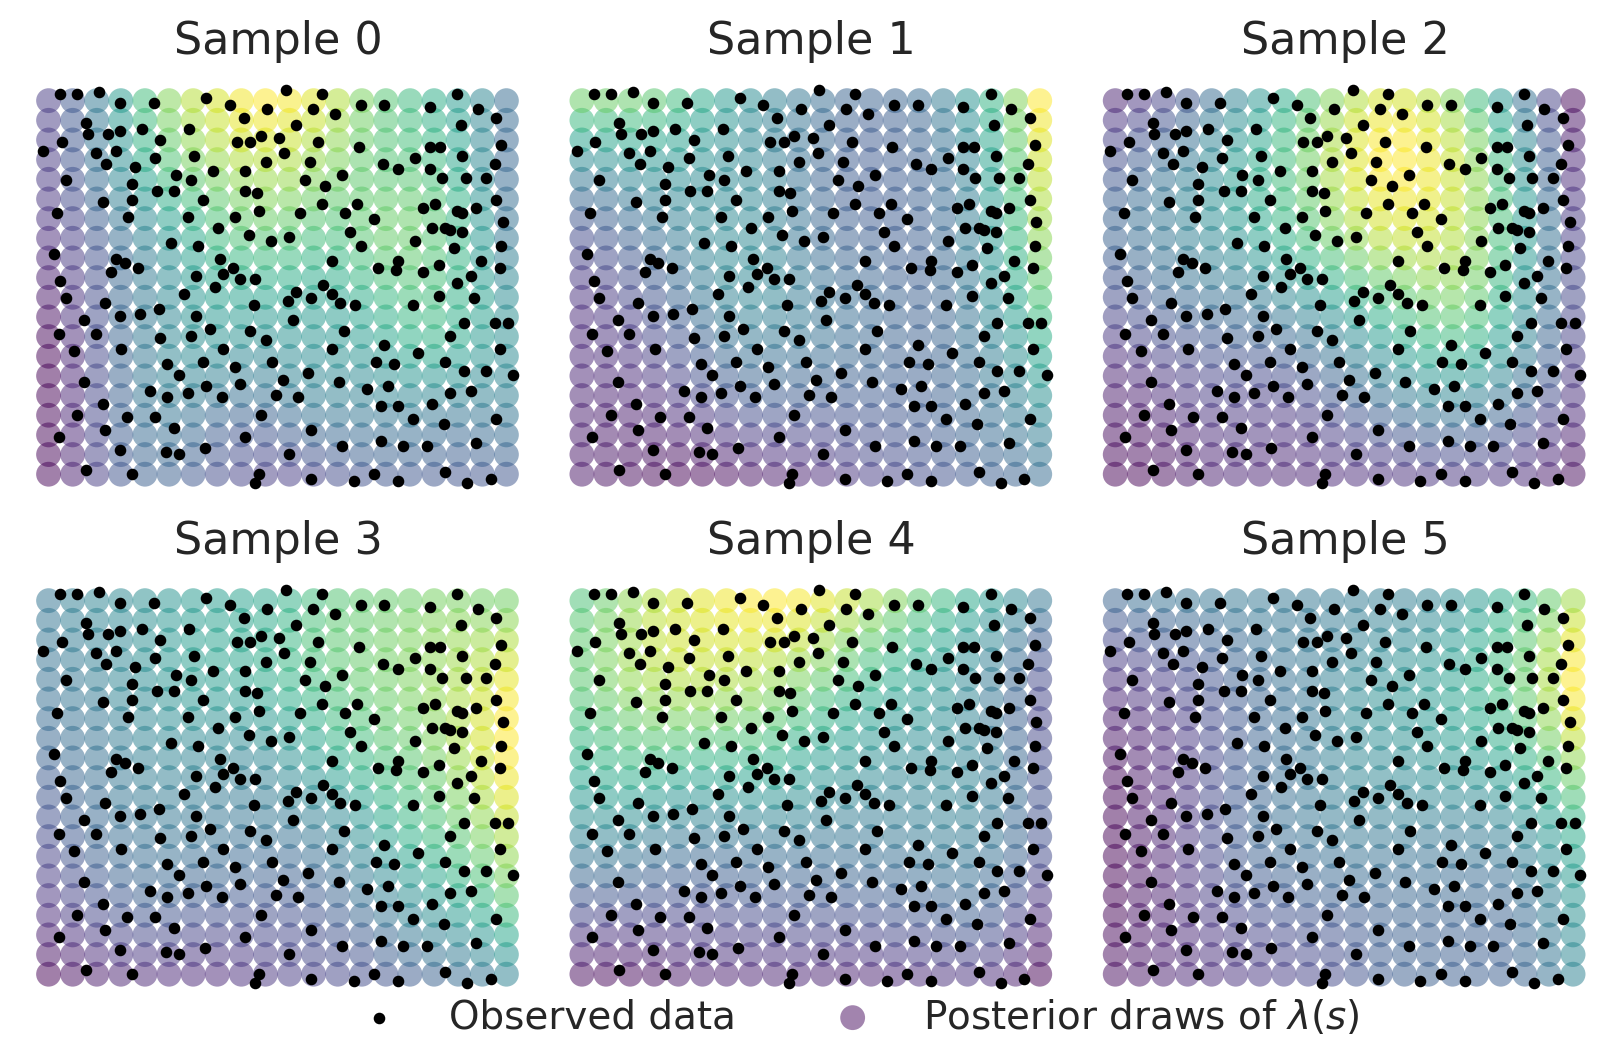

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(8, 5), constrained_layout=True)
axes = axes.ravel()

field_kwargs = {"marker": "o", "edgecolor": "None", "alpha": 0.5, "s": 80}

for i in range(6):
    field_handle = axes[i].scatter(
        xy_new[:, 0], xy_new[:, 1], c=intensity_samples.sel(chain=0, draw=i), **field_kwargs
    )

    obs_handle = axes[i].scatter(data["x"], data["y"], s=10, color="k")
    axes[i].axis("off")
    axes[i].set_title(f"Sample {i}")

plt.figlegend(
    (obs_handle, field_handle),
    ("Observed data", r"Posterior draws of $\lambda(s)$"),
    ncol=2,
    loc=(0.2, -0.01),
    fontsize=14,
    frameon=False,
);

While there is some heterogeneity in the patterns these surfaces show, we obtain a posterior mean surface with a very clearly defined spatial surface with higher intensity in the upper right and lower intensity in the lower left.

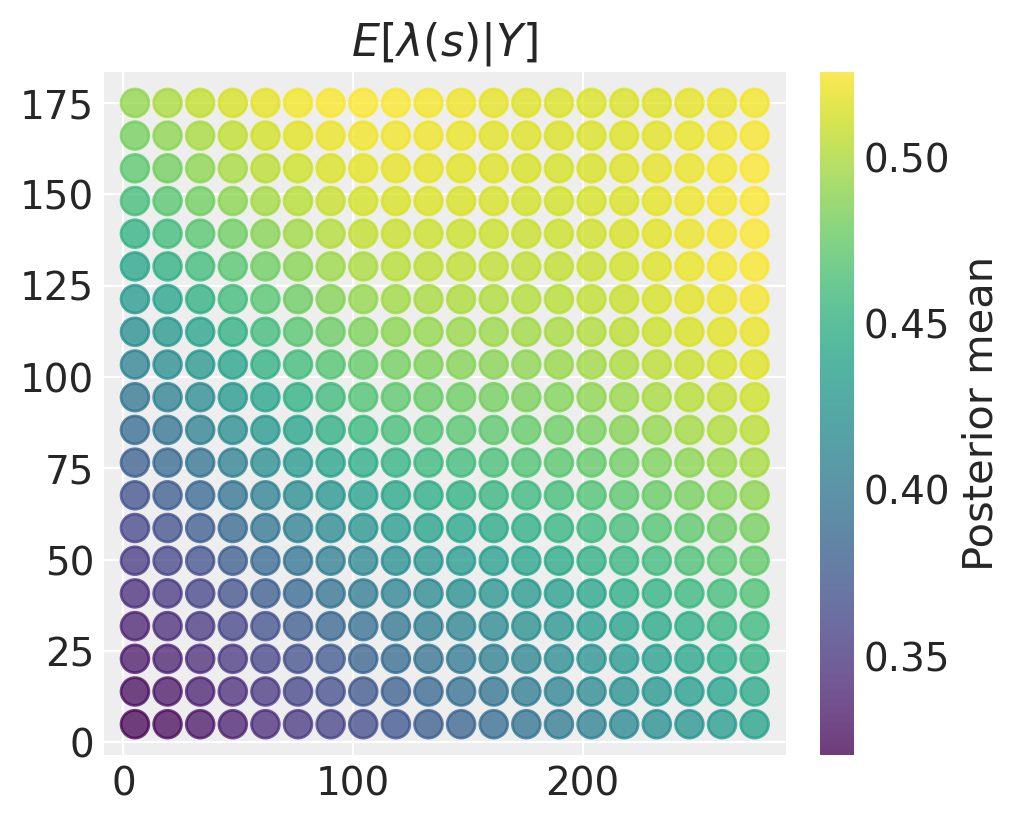

In [14]:
fig = plt.figure(figsize=(5, 4))

plt.scatter(
    xy_new[:, 0],
    xy_new[:, 1],
    c=intensity_samples.mean(("chain", "draw")),
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)

plt.title("$E[\\lambda(s) \\vert Y]$")
plt.colorbar(label="Posterior mean");

The spatial variation in our estimates of the intensity field may not be very meaningful if there is a lot of uncertainty. We can make a similar plot of the posterior variance (or standard deviation) in this case:

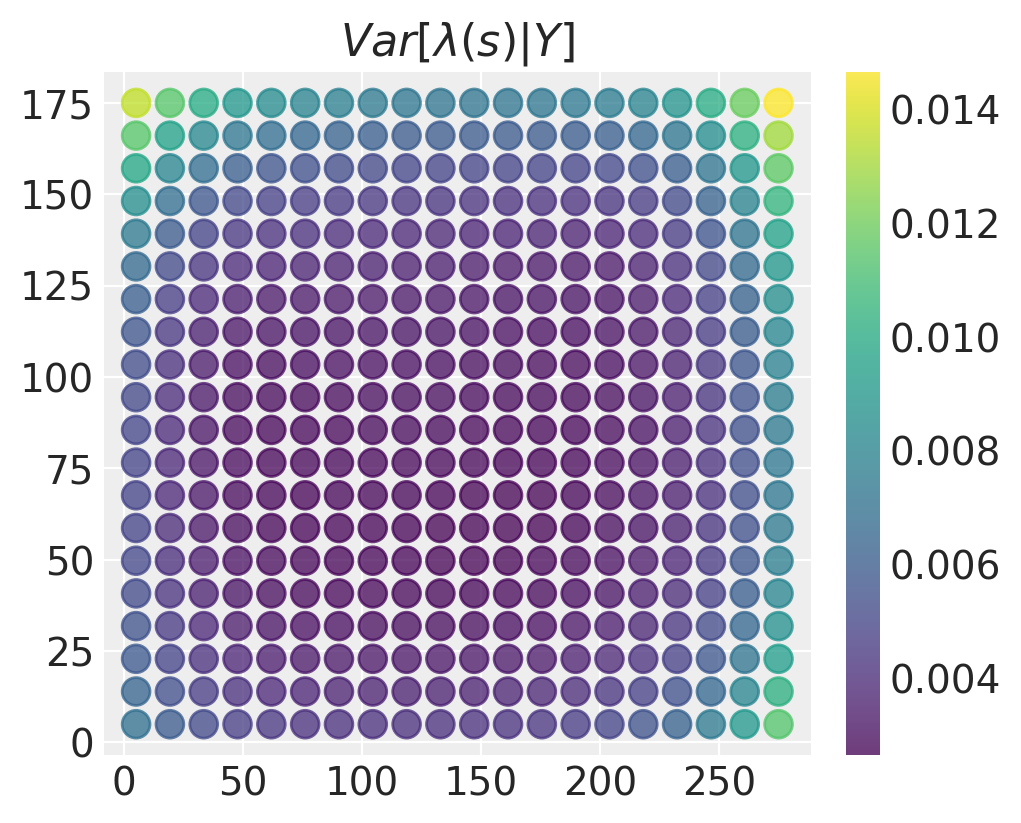

In [15]:
fig = plt.figure(figsize=(5, 4))

plt.scatter(
    xy_new[:, 0],
    xy_new[:, 1],
    c=intensity_samples.var(("chain", "draw")),
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)
plt.title("$Var[\\lambda(s) \\vert Y]$"), plt.colorbar();

The posterior variance is lowest in the middle of the domain and largest in the corners and edges. This makes sense - in locations where there is more data, we have more accurate estimates for what the values of the intensity field may be.

## Authors

- This notebook was written by [Christopher Krapu](https://github.com/ckrapu) on September 6, 2020 and updated on April 1, 2021.
- Updated by Chris Fonnesbeck on May 31, 2022 for v4 compatibility.

## Watermark

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Jun 01 2022

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.1.1

matplotlib: 3.5.1
arviz     : 0.12.0
numpy     : 1.22.2
pymc      : 4.0.0b6
pandas    : 1.4.1
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:24:11) 
[GCC 9.4.0]

Watermark: 2.3.0



:::{include} ../page_footer.md
:::